# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [3]:
fname = "data/corpus.tache1.learn.utf8"

alltxts, alllabs = load_pres(fname)

In [4]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


In [5]:
# def load_movies(path2data): # 1 classe par répertoire
#     alltxts = [] # init vide
#     labs = []
#     cpt = 0
#     for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
#         for f in os.listdir(path2data+cl):
#             txt = open(path2data+cl+'/'+f).read()
#             alltxts.append(txt)
#             labs.append(cpt)
#         cpt+=1 # chg répertoire = cht classe
#     return alltxts,labs

In [6]:
# path = "movies1000/"

# alltxts,alllabs = load_movies(path)

In [7]:
# print(len(alltxts),len(alllabs))
# print(alltxts[0])
# print(alllabs[0])
# print(alltxts[-1])
# print(alllabs[-1])

# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [8]:
import string
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer

def preprocessing(X):
    res = []
    for doc in X:
        punc = string.punctuation  # recupération de la ponctuation
        punc += '\n\r\t'
        doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))
        doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
        doc = doc.lower()
        doc = re.sub('[0-9]+', '', doc)
        res.append(doc)
    return np.array(res)

def formal(X):
    stemmer = SnowballStemmer(language='french')
#     nltk.download('stopwords')
    res = []
    stop = stopwords.words('french')
    for doc in X:
        new_doc = ""
        for w in doc.split():
            if w not in stop:
                new_doc += w + " "
        new_doc = [stemmer.stem(X) for X in new_doc.split()]
        new_doc = " ".join(new_doc)
        res.append(new_doc)
    return res

In [9]:
X = np.array(alltxts[:1000])
Y = np.array(alllabs[:1000])
        
print(X[0])
X_preprocess = preprocessing(X)
print(X_preprocess[0])
X_train = formal(X_preprocess)
print("\n",X_train[0])

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

 quand je dis chers amis  il ne s agit pas la d une formule diplomatique  mais de l expression de ce que je ressens  

 quand dis cher amis agit formul diplomat express ressen


# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


(1000,)
(1000,)


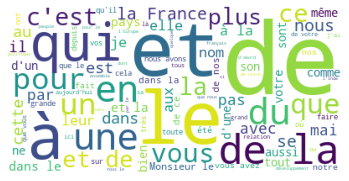

In [10]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

print(X.shape)
print(Y.shape)

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): 
            rt.extend(flatten(i))
        else: 
            rt.append(i)
    return rt

words = "".join(flatten(X))
wordcloud = WordCloud(background_color='white', max_words=100).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# vectorizer = CountVectorizer()
# vector = vectorizer.fit_transform(X).toarray()
# names = vectorizer.get_feature_names()
# print(vector.shape)
# n, m = vector.shape
# vector = np.where(vector == 0, 0, 1)
# sums = vector.sum(axis=0)
# res = np.sort(sums)[sums.size-100:]
# print(res)
# words = "".join(flatten(X))
# wordcloud = WordCloud(background_color='white', max_words=100).generate(words)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

In [11]:
words = "".join(flatten(X_preprocess[:1000]))
unique_words, count = np.unique(words.split(), return_counts=True)

In [12]:
# count = np.where(count > 100, 100, count)
count = np.log(count)

[   1    1    1 ...  713  829 1245]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


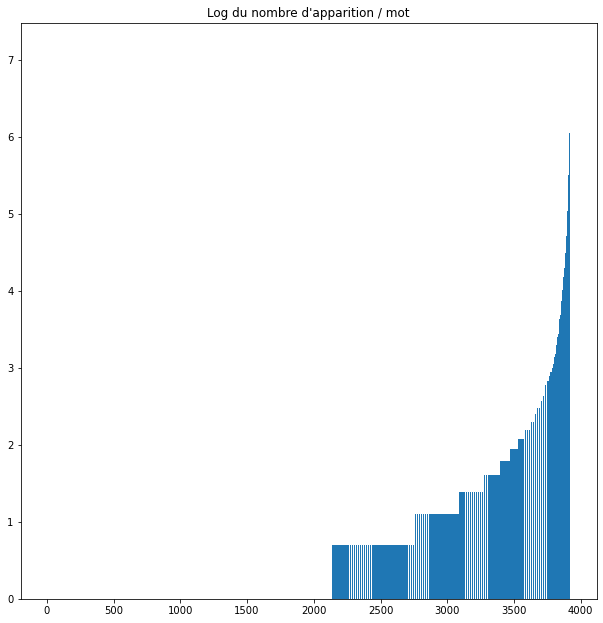

In [13]:
unique_words, count = np.unique(words.split(), return_counts=True)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(count)),np.log(count))
plt.title("Log du nombre d'apparition / mot")
plt.show()

[   1    1    1 ...  713  829 1245]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


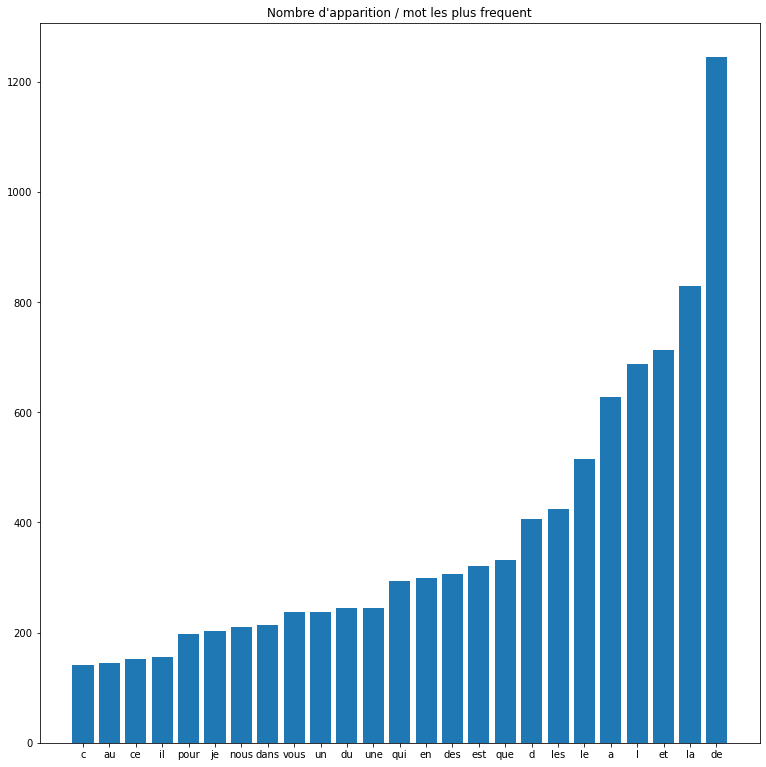

In [14]:
unique_words, count = np.unique(words.split(), return_counts=True)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_words[len(count)-25:],count[len(count)-25:])
plt.title("Nombre d'apparition / mot les plus frequent")
plt.show()

Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?

In [15]:
# On peut le faire assez facilemment avec sklearn
# Cela donne plus de contexte a nos mots mais les probabilites de tri-grammes vont etre tres faible

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [16]:
# Cela prend beaucoup de temps avec des donnees textuels car nous avons un grand nombre de variables
# Cela depend fortement de la taille du vocabulaire
# La validation est tres pratique car on train nos modeles sur toutes les donnes contrairement au split
# Ici on utlise le split car bien plus rapide, on pourra envisager la validation croisee quand on aura deja fait un choix au niveau des modeles

## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

- IL FAUT FAIRE PLEIN DE VARIABLE X_train1 X_train2 ... AVEC DES DONNES EN UTILISANT CountVectorizer() (ngram, preprocess, mindf, maxdf etc...)
- COMPRENDRE LESQUELS SONT LES PLUS IMPORTANTS (mindf, maxdf)
- PUIS APRES IL FAUT EQUILIBRER LES CLASSES
- PUIS OPTIMISER LES MODELES
- PUIS TESTER LES MODELES ET LES COMPARER
- FAIRE DES COURBES PLT POUR MONTRER QU'ON A TROUVER LE MODEL OPTIMAL (mindf/test_acc)

In [17]:
import sklearn.naive_bayes as nb
from sklearn import svm
from sklearn import linear_model as lin
from sklearn.model_selection import train_test_split
import string
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Fonction pour le traitement de donnees

In [18]:
def preprocessing(X):
    res = []
    punc = string.punctuation  
    punc += '\n\r\t'
    for doc in X:    
        doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))
        doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
        doc = doc.lower()
        doc = re.sub('[0-9]+', '', doc)
        res.append(doc)
    return np.array(res)

def formal(X):
    stemmer = SnowballStemmer(language='french')
#     nltk.download('stopwords')
    res = []
    stop = stopwords.words('french')
    for doc in X:
        new_doc = ""
        for w in doc.split():
            if w not in stop:
                new_doc += w + " "
        new_doc = [stemmer.stem(X) for X in new_doc.split()]
        new_doc = " ".join(new_doc)
        res.append(new_doc)
    return res

## Importation des deux fichiers contenant les donnees

In [19]:
fname = "data/corpus.tache1.learn.utf8"
alltxts_test, alllabs_test = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)

fname_test = "data/corpus.tache1.test.utf8"
alltxts_test, alllabs_test = load_pres(fname_test)
X_test = np.array(alltxts_test)
Y_test = np.array(alllabs_test)

## Fonctions permettant de faire notre selection de modele suivant les données

In [20]:
model_names = ["SVC1", "SVC0.8", "SVC0.6", "NB", "LR"]

def train_models_and_get_acc(X_train, X_test, Y_train, Y_test, display):
    print("--> SVC reg=1.0 :")
    clf = svm.LinearSVC(class_weight="balanced", C=1.0)
    clf.fit(X_train, Y_train) 
    acc1 = np.round(clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc1, " %")
    if display : display_infos(clf, X_test, Y_test)
    
    print("--> SVC reg=0.8 :")
    clf = svm.LinearSVC(class_weight="balanced", C=0.8)
    clf.fit(X_train, Y_train) 
    acc2 = np.round(clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc2, " %")
    if display : display_infos(clf, X_test, Y_test)
    
    print("--> SVC reg=0.6 :")
    clf = svm.LinearSVC(class_weight="balanced", C=0.6)
    clf.fit(X_train, Y_train) 
    acc3 = np.round(clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc3, " %")
    if display : display_infos(clf, X_test, Y_test)
    
    print("--> NB :")
    clf = nb.MultinomialNB()
    clf.fit(X_train, Y_train)
    acc4 = np.round(clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc4, " %")
    if display : display_infos(clf, X_test, Y_test)
    
    print("--> LR :")
    clf = lin.LogisticRegression(class_weight="balanced")
    clf.fit(X_train, Y_train)
    acc5 = np.round(clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc5, " %") 
    if display : display_infos(clf, X_test, Y_test)
    
    return [acc1, acc2, acc3, acc4, acc5]

In [21]:
def display_infos(clf, X_test, Y_test):
    # Check le nombre de predictions pour chaque label
    predictions = clf.predict(X_test)
    unique, counts = np.unique(predictions, return_counts=True)
    print("/!\ Prediction counts for label ", unique, " --> ", counts)
    # Check le nombre de predictions pour chaque label
    unique, counts = np.unique(Y_test, return_counts=True)
    print("/!\ Ground truth counts for label ", unique, " --> ", counts)
    # Check la precision du label en inferiorite
    acc = get_inf_acc(predictions, Y_test)
    print("/!\ Accuracy of inferior label :", acc, "%")
    # Check la precision du label en superiorite
    acc = get_sup_acc(predictions, Y_test)
    print("/!\ Accuracy of superior label :", acc, "%\n")

In [22]:
def get_inf_acc(predictions, Y_test):
    idx_inf = np.where(predictions==-1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def get_sup_acc(predictions, Y_test):
    idx_inf = np.where(predictions==1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

In [45]:
def get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer, transformer=None):
    X_vector = vectorizer.fit_transform(X)
    if transformer is not None:
        transformer = transformer.fit(X_vector)
        X_final = transformer.transform(X_vector)
    else:
        X_final = X_vector
    X_test_vector = vectorizer.transform(X_test)
    return X_final, X_test_vector, Y, Y_test

In [24]:
database_models_name = ["vanilla", "ngram22", "maxfeat500", "stopwords", "min2", "min3", "min4", "max0.9", "max0.8", "max0.7", "min3_max0.7", "ngram22_maxfeat500", "tfidfvectorizer"]

In [25]:
def build_database(X, X_test, Y, Y_test):
    database = []

    vectorizer = CountVectorizer()
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    
    vectorizer = CountVectorizer(max_features=500)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    
    stop = stopwords.words('french')
    vectorizer = CountVectorizer(stop_words=stop)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    
    vectorizer = CountVectorizer(min_df=2)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    vectorizer = CountVectorizer(min_df=3)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    vectorizer = CountVectorizer(min_df=4)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    
    vectorizer = CountVectorizer(max_df=0.9)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    vectorizer = CountVectorizer(max_df=0.8)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    vectorizer = CountVectorizer(max_df=0.7)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    
    vectorizer = CountVectorizer(max_df=0.7, min_df=3)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])

    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=500)
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])

    vectorizer = TfidfVectorizer()
    X_train_vector, Y_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
    database.append([X_train_vector, Y_test_vector, Y_train, Y_test])
    
    return np.array(database)

In [26]:
def simulation(db, display=False):
    metrics = []
    for cpt, element in enumerate(db):
        print("---------------- Testing model : ", database_models_name[cpt], " ----------------")
        X_train, X_test, Y_train, Y_test = element
        metrics.append(train_models_and_get_acc(X_train, X_test, Y_train, Y_test, display))
    return metrics

## Model selection manuel

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
# db = build_database(X, X_test, Y, Y_test)

In [29]:
# metrics = simulation(db, display=True)

In [30]:
# metrics = np.array(metrics)
# n_data, n_model = metrics.shape
# print("--> Simulation done on", n_data, "different data processing and", n_model, "different models")
# print("--> Metrics :\n", metrics)
# print("--> Best accuracy :", metrics.max(), "from data model : '", database_models_name[metrics.argmax()//n_model], "' and model :'", model_names[metrics.argmax()%n_model], "'")

## Model selection avec sklearn

In [31]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [32]:
model_names = ["SVC", "NB", "LR"]

def train_models_and_get_acc_sklearn(X_train, X_test, Y_train, Y_test, display):
    print("--> SVC :")
    svc = svm.SVC()
    parameters = {'kernel':(['linear']), 
                  'C':[0.5, 1, 2, 5], 
                  'class_weight':(['balanced'])}
    clf = GridSearchCV(svc, parameters, cv=5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_train, Y_train)
    acc1 = np.round(best_clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc1, " %")
    if display : 
        display_infos(clf, X_test, Y_test)
        performance(best_clf)
    
    print("--> NB :")
    clf = nb.MultinomialNB()
    clf.fit(X_train, Y_train)
    acc2 = np.round(clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc2, " %")
    if display : display_infos(clf, X_test, Y_test)
    
    print("--> LR :")
    lr = LogisticRegression()
    parameters = {'max_iter' : [2000],
                  'penalty' : ['l1', 'l2'],
                  'C' : np.logspace(-4, 4, 20),
                  'solver' : ['liblinear'],
                  'class_weight':(['balanced'])}
    clf = GridSearchCV(lr, parameters, cv=5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_train,Y_train)
    acc3 = np.round(clf.score(X_test, Y_test)*100, 2)
    print("Acc : ", acc3, " %") 
    if display : 
        display_infos(clf, X_test, Y_test)
        performance(best_clf)
    
    return [acc1, acc2, acc3]

In [33]:
def simulation_sklearn(db, display=False):
    metrics = []
    for cpt, element in enumerate(db):
        print("---------------- Testing model : ", database_models_name[cpt], " ----------------")
        X_train, X_test, Y_train, Y_test = element
        metrics.append(train_models_and_get_acc_sklearn(X_train, X_test, Y_train, Y_test, display))
    return metrics

In [34]:
def get_performance(clf):
    print('Best Score: ' + str(clf.best_score_))
    print('Best Parameters: ' + str(clf.best_params_))

In [35]:
# db = build_database(X, X_test, Y, Y_test)

In [36]:
# metrics = simulation_sklearn(db, display=True)

## Model selection + data selection avec sklearn

In [37]:
test_size = 10_000 # Taille des data pour le grid search (MAX = 57400)

### --> Selection de data

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", svm.SVC()),
    ]
)

parameters = {
    "vect__min_df": (0, 1, 2, 3),
    "vect__max_df": (0.5, 0.75, 1.0),
    'vect__max_features': (None, 1000, 2000, 3000),
    "vect__ngram_range": ((1, 1), (1, 2), (1,3)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': (None, 'l1', 'l2'),
    'clf__class_weight':(['balanced'])
    
    # "clf__max_iter": (20,)
    # "clf__alpha": (0.00001, 0.000001),
    # "clf__penalty": ("l2", "elasticnet"),
    # 'clf__max_iter': (10, 50, 80),
}

In [39]:
# grid_search = GridSearchCV(pipeline, parameters, n_jobs=8, verbose=3, cv=5)

In [40]:
X_select, Y_select = X[:test_size], Y[:test_size]

In [41]:
# from time import time

# t0 = time()
# grid_search.fit(list(X_select), list(Y_select))
# print("done in %0.3fs" % (time() - t0))

- 4320 fits et n_jobs=8:
    - Temps pour size=2_000  -> 159s 
    - Temps pour size=10_000 -> 11075s (184 minutes)
    - Temps pour size=20_000 ->

### --> Affichage meilleur paramètres pour la data

In [42]:
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("--->%s: %r" % (param_name, best_parameters[param_name]))

### --> Creation du dataset optimal

In [43]:
fname = "data/corpus.tache1.learn.utf8"
alltxts_test, alllabs_test = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)

fname_test = "data/corpus.tache1.test.utf8"
alltxts_test, alllabs_test = load_pres(fname_test)
X_test = np.array(alltxts_test)
Y_test = np.array(alllabs_test)

In [46]:
transformer = TfidfTransformer(use_idf=True, 
                               norm="l2")
vectorizer = CountVectorizer(max_df=0.75, 
                             min_df=3, 
                             max_features=None, 
                             ngram_range=(1,2)
                            )

X_train_vector, X_test_vector, Y_train, Y_test = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer, transformer)

### --> Verification perte trop grande de mots dans le vocabulaire

In [48]:
print("Avec parametres : ", X_train_vector.shape[1])

vectorizer = CountVectorizer()
test, _, _, _ = get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer)
print("Sans parametres :", test.shape[1])

Avec parametres :  72858
Sans parametres : 28524


### --> Selection de model en partant d'un dataset optimal

In [49]:
X_select, Y_select = X_train_vector[:test_size], Y_train[:test_size]

In [50]:
svc = svm.SVC()
parameters = {'kernel':(['linear']), 
              'C':np.arange(0, 1, 0.1), 
              'class_weight':(['balanced'])}

In [51]:
# t0 = time()
# clf = GridSearchCV(svc, parameters, n_jobs=8, cv=5, verbose=3)
# best_clf = clf.fit(X_select, Y_select)
# print("done in %0.3fs" % (time() - t0))

In [52]:
# best_parameters = clf.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("--->%s: %r" % (param_name, best_parameters[param_name]))

- 50 fits, njobs=8:
    - size=10_000 --> 88s

### --> Entrainement final après avoir selectionner les data et le modele

In [53]:
test_size = 5_000

X_select, Y_select = X_train_vector[:test_size], Y_train[:test_size]

In [54]:
optimal_model = svm.SVC(C=0.3, 
              class_weight="balanced", 
              kernel="linear")
optimal_model.fit(X_select, Y_select)

SVC(C=0.3, class_weight='balanced', kernel='linear')

In [55]:
test_size = 5_000

X_select, Y_select = X_test_vector[:test_size], Y_test[:test_size]

In [56]:
acc = np.round(optimal_model.score(X_select, Y_select)*100, 2)

In [57]:
print("Acc : ", acc, " %")
display_infos(optimal_model, X_select, Y_select)

Acc :  35.46  %
/!\ Prediction counts for label  [-1  1]  -->  [3375 1625]
/!\ Ground truth counts for label  [-1  1]  -->  [ 482 4518]
/!\ Accuracy of inferior label : 9.33 %
/!\ Accuracy of superior label : 89.72 %



## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \mbox{si } y_i \in \mbox{classe majoritaire}\\
B>1 & \mbox{si } y_i \in \mbox{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

## 1. Balancing

In [58]:
label, count = np.unique(Y, return_counts=True)

idx_pos = np.where(Y == 1, True, False)
Y_pos = Y[idx_pos]
Y_pos = Y_pos[:count.min()]

idx_neg = np.where(Y == -1, True, False)
Y_neg = Y[idx_neg]

new_Y = np.concatenate((Y_pos, Y_neg))
new_X = np.concatenate((X[:count.min()], X[idx_neg]))

print(new_Y.shape)
print(new_X.shape)

(15046,)
(15046,)


In [59]:
label, count = np.unique(new_Y, return_counts=True)
print(label, count)

[-1  1] [7523 7523]


In [60]:
transformer = TfidfTransformer(use_idf=True, 
                               norm="l2")
vectorizer = CountVectorizer(max_df=0.75, 
                             min_df=3, 
                             max_features=None, 
                             ngram_range=(1,2)
                            )
X_train_vector, X_test_vector, Y_train, Y_test = get_all_data_vectorized(new_X, X_test, new_Y, Y_test, vectorizer, transformer)

optimal_model = svm.SVC(C=0.3, 
              class_weight="balanced", 
              kernel="linear")

# test_size = 7500
# X_select, Y_select = X_train_vector[:test_size], Y_train[:test_size]
# optimal_model.fit(X_select, Y_select)

In [61]:
# test_size = 1000
# X_select, Y_select = X_test_vector[:test_size], Y_test[:test_size]
# print("Acc : ", acc, " %")
# display_infos(optimal_model, X_select, Y_select)
# acc = np.round(optimal_model.score(X_select, Y_select)*100, 2)

## 2. Cost function modification

## 3. ROC curves